In [198]:
from __future__ import division, print_function
import kf_book.pf_internal as pf_internal
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import uniform
from filterpy.stats import plot_gaussian_pdf
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import operator
from collections import Counter

In [9]:
from numpy.random import uniform

def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles

def create_gaussian_particles(mean, std, N):
    particles = np.empty((N, 3))
    particles[:, 0] = mean[0] + (randn(N) * std[0])
    particles[:, 1] = mean[1] + (randn(N) * std[1])
    particles[:, 2] = mean[2] + (randn(N) * std[2])
    particles[:, 2] %= 2 * np.pi
    return particles

In [10]:
########################
##### Predict Step #####
########################

def predict(particles, u, std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += u[0] + (randn(N) * std[0])
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (randn(N) * std[1])
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist

In [11]:
#######################
##### Update Step #####
#######################


def update(particles, weights, z, R, landmarks):
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(distance, R).pdf(z[i])

    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize

In [12]:
#################################
##### State Estimation Step #####
#################################

def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

In [13]:
#############################
#### Particle Resampling ####
#############################

def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, random(N))

    # resample according to indexes
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)
    
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights[:] = weights[indexes]
    weights.fill(1.0 / len(weights))    

def neff(weights):
    return 1. / np.sum(np.square(weights))

In [320]:
####################################
#### Transition Matrix Training ####
####################################

def PredLookup(item, index, predlist):
    # print(index)
    # print(predlist[index - 1][1])
    if (predlist[index - 1][1] == item):
        return False;
    else:
        return True;
    

agenttrace = '../4jul11p.csv'
f = open(agenttrace)
#print(f.readlines)
oracle = []
gridized_data = []
gridsize = 0.5

xbins = 13
ybins = 21

# Based on Smart Condo Dimension and orientation:
TMatrix = np.zeros((xbins * ybins, xbins * ybins))
TLookupTable = []

for x in range(xbins):
    for y in range(ybins):
        TLookupTable.append("[" + str(x) + ", " + str(y) + "]")
        
with open(agenttrace, 'r') as user_data:
    reader = csv.reader(user_data, delimiter=',', quotechar=',')
    for row in reader:
        if (reader.line_num > 1):
            oracle.append([float(row[4]), float(row[5])])
            
for d in oracle:
    gridized_data.append([int(np.floor(d[0]/gridsize)), int(np.floor(d[1]/gridsize))])        
    
for x in range(xbins):
    for y in range(ybins):
        # find (x, y)s in gridized_data
        indices = [index for index, item in enumerate(gridized_data) if item == [x, y] and 
                   PredLookup(item, index, list(zip(gridized_data[1:], gridized_data)))]  
        
        # foreach (x, y): find their next successor; N = total number of successors 
        if not indices:
            print("Agent was not in location [" + str(x) + ", " + str(y) + "] at all")
        else:
            # print([x, y])
            # print(operator.itemgetter(*indices)(gridized_data))
            print(indices)
            # print(gridized_data[for i in indices])
            
            print("shadan")
            N = len(indices)
            next_indices = [x + 1 for x in indices]
            
            next_states = [gridized_data[i] for i in next_indices]
            
            # next_states = [operator.itemgetter(*next_indices)(gridized_data)]
            
            print(next_states)
            
            print("golestan")
            
            for next_state in next_states:
                n = next_states.count(next_state)
                # print(TLookupTable)
                # print(TLookupTable.index(next_state))
                
                cell = TLookupTable.index(str(next_state))
                TMatrix[x, cell] = float(n / N)

Agent was not in location [0, 0] at all
Agent was not in location [0, 1] at all
Agent was not in location [0, 2] at all
Agent was not in location [0, 3] at all
Agent was not in location [0, 4] at all
Agent was not in location [0, 5] at all
Agent was not in location [0, 6] at all
Agent was not in location [0, 7] at all
Agent was not in location [0, 8] at all
Agent was not in location [0, 9] at all
Agent was not in location [0, 10] at all
Agent was not in location [0, 11] at all
Agent was not in location [0, 12] at all
Agent was not in location [0, 13] at all
Agent was not in location [0, 14] at all
Agent was not in location [0, 15] at all
Agent was not in location [0, 16] at all
Agent was not in location [0, 17] at all
Agent was not in location [0, 18] at all
Agent was not in location [0, 19] at all
Agent was not in location [0, 20] at all
Agent was not in location [1, 0] at all
Agent was not in location [1, 1] at all
Agent was not in location [1, 2] at all
Agent was not in location [1,

[[9, 9]]
golestan
Agent was not in location [8, 10] at all
Agent was not in location [8, 11] at all
[1498]
shadan
[[8, 12]]
golestan
[5502]
shadan
[[8, 13]]
golestan
[36, 52, 60]
shadan
[[9, 15], [4, 10], [11, 17]]
golestan
[82, 5496]
shadan
[[7, 14], [8, 15]]
golestan
Agent was not in location [8, 16] at all
Agent was not in location [8, 17] at all
Agent was not in location [8, 18] at all
Agent was not in location [8, 19] at all
Agent was not in location [8, 20] at all
Agent was not in location [9, 0] at all
Agent was not in location [9, 1] at all
Agent was not in location [9, 2] at all
[1152]
shadan
[[9, 3]]
golestan
[1149, 1250]
shadan
[[9, 4], [9, 6]]
golestan
[1147]
shadan
[[9, 5]]
golestan
[1146, 1251]
shadan
[[9, 5], [10, 7]]
golestan
Agent was not in location [9, 7] at all
Agent was not in location [9, 8] at all
[1060]
shadan
[[10, 10]]
golestan
Agent was not in location [9, 10] at all
[1496]
shadan
[[9, 11]]
golestan
[5504]
shadan
[[9, 12]]
golestan
Agent was not in location [

In [401]:
def transition_matrix(transitions, xbins, ybins):
    states_lookup_table = []
    for x in range(xbins):
        for y in range(ybins):
            states_lookup_table.append("[" + str(x) + ", " + str(y) + "]")

    print(states_lookup_table)
    n = 1 + len(np.array(list(set(tuple(p) for p in transitions)))) #number of unique states
    
    M = np.zeros((xbins * ybins, xbins * ybins))
    # M = [[0]*n for _ in range(n)]

    for (state, state_p) in zip(transitions,transitions[1:]):
        i = state[0]*xbins + state[1]
        j = state_p[0]*xbins + state_p[1]
        # i = states_lookup_table.index(str(state))
        # j = states_lookup_table.index(str(state_p))
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M



In [402]:
#test:

agenttrace = '../4jul11p.csv'
f = open(agenttrace)
#print(f.readlines)
oracle = []
gridized_data = []

# Information Granularity
                
gridsize = 1
realx = 6.6
realy = 10.6
                
xbins = int(np.ceil(realx) / gridsize) + 1
ybins = int(np.ceil(realy) / gridsize) + 1


with open(agenttrace, 'r') as user_data:
    reader = csv.reader(user_data, delimiter=',', quotechar=',')
    for row in reader:
        if (reader.line_num > 1):
            oracle.append([float(row[4]), float(row[5])])
            
for d in oracle:
    gridized_data.append([int(np.floor(d[0]/gridsize)), int(np.floor(d[1]/gridsize))])        
           
print(xbins)                
print(ybins)

m = transition_matrix(gridized_data, xbins, ybins)
                
for row in m: 
    print(' '.join('{0:.2f}'.format(x) for x in row))

8
12
['[0, 0]', '[0, 1]', '[0, 2]', '[0, 3]', '[0, 4]', '[0, 5]', '[0, 6]', '[0, 7]', '[0, 8]', '[0, 9]', '[0, 10]', '[0, 11]', '[1, 0]', '[1, 1]', '[1, 2]', '[1, 3]', '[1, 4]', '[1, 5]', '[1, 6]', '[1, 7]', '[1, 8]', '[1, 9]', '[1, 10]', '[1, 11]', '[2, 0]', '[2, 1]', '[2, 2]', '[2, 3]', '[2, 4]', '[2, 5]', '[2, 6]', '[2, 7]', '[2, 8]', '[2, 9]', '[2, 10]', '[2, 11]', '[3, 0]', '[3, 1]', '[3, 2]', '[3, 3]', '[3, 4]', '[3, 5]', '[3, 6]', '[3, 7]', '[3, 8]', '[3, 9]', '[3, 10]', '[3, 11]', '[4, 0]', '[4, 1]', '[4, 2]', '[4, 3]', '[4, 4]', '[4, 5]', '[4, 6]', '[4, 7]', '[4, 8]', '[4, 9]', '[4, 10]', '[4, 11]', '[5, 0]', '[5, 1]', '[5, 2]', '[5, 3]', '[5, 4]', '[5, 5]', '[5, 6]', '[5, 7]', '[5, 8]', '[5, 9]', '[5, 10]', '[5, 11]', '[6, 0]', '[6, 1]', '[6, 2]', '[6, 3]', '[6, 4]', '[6, 5]', '[6, 6]', '[6, 7]', '[6, 8]', '[6, 9]', '[6, 10]', '[6, 11]', '[7, 0]', '[7, 1]', '[7, 2]', '[7, 3]', '[7, 4]', '[7, 5]', '[7, 6]', '[7, 7]', '[7, 8]', '[7, 9]', '[7, 10]', '[7, 11]']
0.00 0.00 0.00 0.0

In [395]:
gridsize = 0.5
realx = 6.6
realy = 10.6
                
xbins = int(np.ceil(realx) / gridsize) + 1
ybins = int(np.ceil(realy) / gridsize) + 1

print(xbins)
print(ybins)

states_lookup_table = []
for x in range(xbins):
        for y in range(ybins):
            states_lookup_table.append("[" + str(x) + ", " + str(y) + "]")


15
23


In [397]:
with open(agenttrace, 'r') as user_data:
    reader = csv.reader(user_data, delimiter=',', quotechar=',')
    for row in reader:
        if (reader.line_num > 1):
            oracle.append([float(row[4]), float(row[5])])
            
for d in oracle:
    gridized_data.append([int(np.floor(d[0]/gridsize)), int(np.floor(d[1]/gridsize))])        

In [399]:
gridized_data

[[2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [3, 6],
 [3, 6],
 [3, 6],
 [4, 7],
 [4, 7],
 [4, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [4, 7],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [4, 7],
 [5, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [5, 8],
 [4, 8],
 [4, 7],
 [3, 7],
 [3, 6],
 [2, 6],
 [2, 6],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 [2, 5],
 

In [400]:
states_lookup_table

['[0, 0]',
 '[0, 1]',
 '[0, 2]',
 '[0, 3]',
 '[0, 4]',
 '[0, 5]',
 '[0, 6]',
 '[0, 7]',
 '[0, 8]',
 '[0, 9]',
 '[0, 10]',
 '[0, 11]',
 '[0, 12]',
 '[0, 13]',
 '[0, 14]',
 '[0, 15]',
 '[0, 16]',
 '[0, 17]',
 '[0, 18]',
 '[0, 19]',
 '[0, 20]',
 '[0, 21]',
 '[0, 22]',
 '[1, 0]',
 '[1, 1]',
 '[1, 2]',
 '[1, 3]',
 '[1, 4]',
 '[1, 5]',
 '[1, 6]',
 '[1, 7]',
 '[1, 8]',
 '[1, 9]',
 '[1, 10]',
 '[1, 11]',
 '[1, 12]',
 '[1, 13]',
 '[1, 14]',
 '[1, 15]',
 '[1, 16]',
 '[1, 17]',
 '[1, 18]',
 '[1, 19]',
 '[1, 20]',
 '[1, 21]',
 '[1, 22]',
 '[2, 0]',
 '[2, 1]',
 '[2, 2]',
 '[2, 3]',
 '[2, 4]',
 '[2, 5]',
 '[2, 6]',
 '[2, 7]',
 '[2, 8]',
 '[2, 9]',
 '[2, 10]',
 '[2, 11]',
 '[2, 12]',
 '[2, 13]',
 '[2, 14]',
 '[2, 15]',
 '[2, 16]',
 '[2, 17]',
 '[2, 18]',
 '[2, 19]',
 '[2, 20]',
 '[2, 21]',
 '[2, 22]',
 '[3, 0]',
 '[3, 1]',
 '[3, 2]',
 '[3, 3]',
 '[3, 4]',
 '[3, 5]',
 '[3, 6]',
 '[3, 7]',
 '[3, 8]',
 '[3, 9]',
 '[3, 10]',
 '[3, 11]',
 '[3, 12]',
 '[3, 13]',
 '[3, 14]',
 '[3, 15]',
 '[3, 16]',
 '[3, 17

In [350]:
for (i,j) in zip(gridized_data,gridized_data[1:]):
    print(i)
    print(j)
    print("____")

[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[5, 11]
____
[5, 11]
[6, 12]
____
[6, 12]
[6, 13]
____
[6, 13]
[7, 13]
____
[7, 13]
[8, 14]
____
[8, 14]
[9, 15]
____
[9, 15]
[9, 16]
____
[9, 16]
[10, 17]
____
[10, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
_

[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____


[12, 13]
____
[12, 13]
[12, 13]
____
[12, 13]
[12, 13]
____
[12, 13]
[12, 13]
____
[12, 13]
[12, 13]
____
[12, 13]
[12, 13]
____
[12, 13]
[12, 13]
____
[12, 13]
[12, 13]
____
[12, 13]
[12, 13]
____
[12, 13]
[12, 13]
____
[12, 13]
[12, 13]
____
[12, 13]
[12, 13]
____
[12, 13]
[12, 13]
____
[12, 13]
[12, 13]
____
[12, 13]
[12, 13]
____
[12, 13]
[12, 13]
____
[12, 13]
[12, 13]
____
[12, 13]
[12, 13]
____
[12, 13]
[12, 13]
____
[12, 13]
[12, 13]
____
[12, 13]
[12, 14]
____
[12, 14]
[12, 14]
____
[12, 14]
[12, 14]
____
[12, 14]
[12, 14]
____
[12, 14]
[12, 14]
____
[12, 14]
[12, 14]
____
[12, 14]
[12, 14]
____
[12, 14]
[12, 14]
____
[12, 14]
[12, 14]
____
[12, 14]
[12, 14]
____
[12, 14]
[12, 14]
____
[12, 14]
[12, 14]
____
[12, 14]
[12, 14]
____
[12, 14]
[12, 14]
____
[12, 14]
[12, 14]
____
[12, 14]
[12, 14]
____
[12, 14]
[12, 14]
____
[12, 14]
[12, 14]
____
[12, 14]
[12, 14]
____
[12, 14]
[12, 14]
____
[12, 14]
[12, 14]
____
[12, 14]
[12, 14]
____
[12, 14]
[12, 14]
____
[12, 14]
[12, 14]
__

[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6

[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6]
____
[6, 6]
[6, 6

____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[4, 14]
____
[4, 14]
[3, 15]
____
[3, 15]
[3, 15]
____
[3, 15]
[2, 16]
____
[2, 16]
[1, 16]
____
[1, 16]
[1, 16]
____
[1, 16]
[1, 17]
____
[1, 17]
[1, 17]
____
[1, 17]
[1, 18]
____
[1, 18]
[2, 18]
____
[2, 18]
[2, 18]
____
[2, 18]
[2, 19]
____
[2, 19]
[3, 19]
____
[3, 19]
[3, 20]
____
[3, 20]
[3, 20]
____
[3, 20]
[3, 20]
____
[3, 20]
[3, 20]
____
[3, 20]
[3, 20]
____
[3, 20]
[3, 20]
____
[3, 20]


____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]
[5, 14]
____
[5, 14]


[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____


[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____


____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]
[4, 10]
____
[4, 10]


[6, 12]
[6, 13]
____
[6, 13]
[6, 13]
____
[6, 13]
[6, 13]
____
[6, 13]
[6, 13]
____
[6, 13]
[6, 14]
____
[6, 14]
[6, 14]
____
[6, 14]
[7, 14]
____
[7, 14]
[7, 14]
____
[7, 14]
[7, 14]
____
[7, 14]
[7, 14]
____
[7, 14]
[7, 14]
____
[7, 14]
[7, 15]
____
[7, 15]
[7, 15]
____
[7, 15]
[7, 15]
____
[7, 15]
[7, 15]
____
[7, 15]
[7, 15]
____
[7, 15]
[7, 15]
____
[7, 15]
[9, 16]
____
[9, 16]
[9, 16]
____
[9, 16]
[10, 17]
____
[10, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11, 17]
[11, 17]
____
[11,

[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6

[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6]
____
[1, 6]
[1, 6

In [351]:
gridized_data

[[4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [5, 11],
 [6, 12],
 [6, 13],
 [7, 13],
 [8, 14],
 [9, 15],
 [9, 16],
 [10, 17],
 [11, 17],
 [11, 17],
 [11, 17],
 [11, 17],
 [11, 17],
 [11, 17],
 [11, 17],
 [11, 17],
 [11, 17],
 [11, 17],
 [11, 17],
 [11, 17],
 [8, 14],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [8, 14],
 [11, 17],
 [11, 17],
 [11, 17],
 [11, 17],
 [11, 17],
 [11, 17],
 [11, 17],
 [11, 17],
 [11, 17],
 [11, 17],
 [11, 17],
 [11, 17],
 [11, 17],
 [11, 17],
 [11, 17],
 [11, 17],
 [11, 17],
 [11, 17],
 [11, 17],
 [10, 17],
 [9, 16],
 [8, 15],
 [7, 14],
 [6, 13],
 [5, 13],
 [4, 12],
 [3, 11],
 [2, 10],
 [2, 10],
 [3, 10],
 [3, 10],
 [3, 10],
 [4, 10],
 [4, 10],
 [4, 10],
 [4, 10

In [22]:
from filterpy.monte_carlo import systematic_resample
from numpy.linalg import norm
from numpy.random import randn
import scipy.stats

def run_pf1(N, iters=18, sensor_std_err=.1, do_plot=True, plot_particles=False, xlim=(0, 20), ylim=(0, 20), initial_x=None):
    
    #TODO: (Sensor Model)
    landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]])
    NL = len(landmarks)
    plt.figure()
   
    # create particles and weights
    particles = create_uniform_particles((0,20), (0,20), (0, 6.28), N)    
    weights = np.ones(N) / N

    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(N)           
        plt.scatter(particles[:, 0], particles[:, 1], 
                    alpha=alpha, color='g')
    
    xs = []
    robot_pos = np.array([0., 0.])
    for x in range(iters):
        #TODO: (Motion Model)
        robot_pos += (1, 1)

        # distance from subject to each landmark
        #TODO: Need to be changed!
        zs = (norm(landmarks - robot_pos, axis=1) + (randn(NL) * sensor_std_err))

        
        # move diagonally forward to (x+1, x+1)
        predict(particles, u=(0.00, 1.414), std=(.2, .05))
        
        # incorporate measurements
        update(particles, weights, z = zs, R = sensor_std_err, landmarks = landmarks)
        
        
        
        
        
        
        
        
        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)
        mu, var = estimate(particles, weights)
        xs.append(mu)

        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1], color='k', marker=',', s=1)
        
        p1 = plt.scatter(robot_pos[0], robot_pos[1], marker='+', color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r')
    
    xs = np.array(xs)
    #plt.plot(xs[:, 0], xs[:, 1])
    plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
    plt.show()

final position error, variance:
	 [-0.10621456  0.1061402 ] [0.00859646 0.00757081]


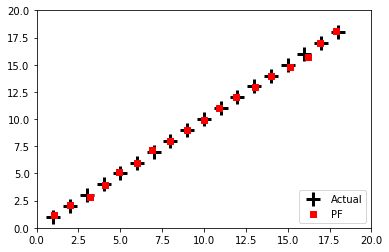

In [23]:
from numpy.random import seed
seed(2) 
run_pf1(N=5000, plot_particles=False)